In [30]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from scipy.signal import medfilt
import random


In [4]:
# from matplotlib import cm
# import vcf
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
# import matplotlib.patches as mpatches
# import matplotlib.lines as mlines
# import statistics
# import allel
# from collections import defaultdict
# from itertools import combinations
# from haversine import haversine
# from skbio.stats.distance import mantel
# from scipy.stats import ttest_ind
# import random
# import time
# import multiprocessing as mp
# from matplotlib.colors import ListedColormap
# from IPython.display import Image


In [2]:
proj_dir="/master/nplatt/sch_hae_scan"
results_dir="{}/results".format(proj_dir)

In [3]:
os.chdir(proj_dir)

In [84]:
#now add sample info (including location data)
info_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")
info_df = info_df.loc[info_df["pca_species"] == "s_haematobium"].reset_index(drop=True)
info_df

,sample_name,1,2,3,4,5,6,7,8,9,...,locale,host,phenotype,project,data_type,lat,lon,kmeans_group,pca_species,kmeans_label
0,Sh_NG_eb_6_2,-0.020753,-0.053674,-0.036507,0.055742,0.020015,0.007856,-0.099560,-0.187863,0.119891,...,ebonyi,human,haematobium,nigeria,genome,6.328611,8.082222,0,s_haematobium,sh_nw
1,Sh_NG_ed_1_3,0.015629,-0.067097,-0.011014,-0.034106,-0.010618,-0.035688,-0.033816,-0.034728,0.091275,...,edo,human,haematobium,nigeria,genome,NaN,NaN,0,s_haematobium,sh_nw
2,Sh_NG_ed_3_2,0.002273,-0.064969,-0.042989,0.077527,-0.012493,-0.057633,-0.022871,-0.148385,0.203648,...,edo,human,haematobium,nigeria,genome,NaN,NaN,0,s_haematobium,sh_nw
3,Sh_NG_kb_2_1,0.013430,-0.074629,-0.037357,-0.007408,0.020214,-0.028320,-0.020860,-0.204342,0.175025,...,kebbi,human,haematobium,nigeria,genome,11.710000,4.052222,0,s_haematobium,sh_nw
4,Sh_NG_kw_1_10,0.011063,-0.070288,-0.024627,-0.034762,0.016050,-0.014678,-0.004198,-0.100453,0.093906,...,kwara,human,haematobium,nigeria,genome,8.892222,5.451389,0,s_haematobium,sh_nw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,ssp_niger_libore_167,0.023576,-0.078099,-0.011150,-0.061000,0.017043,-0.045486,0.040388,-0.017674,0.024366,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
140,ssp_niger_libore_168,0.022321,-0.076938,-0.018901,-0.060000,0.006243,-0.004137,0.029055,-0.042276,0.080228,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
141,ssp_niger_libore_169,0.023969,-0.073719,-0.019718,-0.050199,0.016409,-0.015895,0.038597,-0.020768,0.037634,...,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium,sh_nw
142,ssp_niger_libore_173,0.026690,-0.083394,-0.003446,-0.070261,-0.010403,-0.085303,0.096133,-0.115088,0.082561,...,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium,sh_nw


In [5]:
Path(f"{results_dir}/zw_cov").mkdir(parents=True, exist_ok=True)

os.chdir(f"{results_dir}/zw_cov")

In [7]:
%%bash 

echo -e """NC_067195.1\t0\t10000000
NC_067195.1\t10000000\t45000000
NC_067195.1\t45000000\t89168492""">par.bed

In [85]:
info_df["sample_name"].to_csv("samples.list", sep=",", header=False, index=False)

In [11]:
!conda run -n bedtools bedtools makewindows -g ../../data/GCF_000699445.3_UoM_Shae.V3_genomic.fna.fai -w 10000 | grep NC_067195.1 >zw_windows.bed

In [44]:
%%bash

GENOME="/master/nplatt/sch_hae_scan/data/GCF_000699445.3_UoM_Shae.V3_genomic.fna"

for SAMPLE in $(cat samples.list); do
    #echo $SAMPLE
    
    BAM="/master/nplatt/sch_hae_scan/results/mapped_reads/${SAMPLE}_processed.cram"

    WINDOW_QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 4 -N ${SAMPLE}.windows -o ${SAMPLE}.windows.log" 
    WINDOW_CMD="conda run -n mosdepth mosdepth -t 4 -b zw_windows.bed -f ${GENOME} -n ${SAMPLE}.windows.mean ${BAM}"
    echo $WINDOW_CMD | $WINDOW_QSUB

    PAR_QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 1 -N ${SAMPLE}.par -o ${SAMPLE}.par.log" 
    PAR_CMD="conda run -n mosdepth mosdepth -t 1 -b par.bed -f ${GENOME} -n ${SAMPLE}.par.mean ${BAM}"
    echo $PAR_CMD | $PAR_QSUB

    GENOME_QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y -pe smp 4 -N ${SAMPLE}.par -o ${SAMPLE}.genome.log" 
    GENOME_CMD="conda run -n mosdepth mosdepth -t 4 -f ${GENOME} -n ${SAMPLE}.genome.mean $BAM"
    echo $GENOME_CMD | $GENOME_QSUB

done

Your job 1323393 ("Sb_NG_au_1.2.windows") has been submitted
Your job 1323394 ("Sb_NG_au_1.2.par") has been submitted
Your job 1323395 ("Sb_NG_au_1.2.par") has been submitted
Your job 1323396 ("Sb_NG_au_2.10.windows") has been submitted
Your job 1323397 ("Sb_NG_au_2.10.par") has been submitted
Your job 1323398 ("Sb_NG_au_2.10.par") has been submitted
Your job 1323399 ("Sb_NG_au_2.13.windows") has been submitted
Your job 1323400 ("Sb_NG_au_2.13.par") has been submitted
Your job 1323401 ("Sb_NG_au_2.13.par") has been submitted
Your job 1323402 ("Sb_NG_au_2.5.windows") has been submitted
Your job 1323403 ("Sb_NG_au_2.5.par") has been submitted
Your job 1323404 ("Sb_NG_au_2.5.par") has been submitted
Your job 1323405 ("Sb_NG_au_2.6.windows") has been submitted
Your job 1323406 ("Sb_NG_au_2.6.par") has been submitted
Your job 1323407 ("Sb_NG_au_2.6.par") has been submitted
Your job 1323408 ("Sb_NG_be_1.10.windows") has been submitted
Your job 1323409 ("Sb_NG_be_1.10.par") has been submitted

In [86]:
# Assume 'samples' is already defined and loaded
samples = pd.read_csv("samples.list", header=None)
samples = list(samples[0])

# Initialize an empty list to store data
summary_data = []

for sample in samples:
    summary_file = f"{sample}.genome.mean.mosdepth.summary.txt"
    par_file = f"{sample}.par.mean.regions.bed.gz"

    # Load data
    summary_df = pd.read_csv(summary_file, sep='\t', header=0)
    par_df = pd.read_csv(par_file, sep='\t', header=None,
                         names=['chrom', 'start', 'end', 'cov'],
                         dtype={'chrom': str, 'start': int, 'end': int, 'cov': float})

    # Extracting necessary data
    genome_mean = summary_df.loc[summary_df["chrom"] == "total", "mean"].values[0]
    chr_zw_mean = summary_df.loc[summary_df["chrom"] == "NC_067195.1", "mean"].values[0]
    par1_mean = par_df.iloc[0]["cov"]
    z_mean = par_df.iloc[1]["cov"]
    par2_mean = par_df.iloc[2]["cov"]

    # Append data to the list as a dictionary
    summary_data.append({
        'sample': sample,
        'genome_mean': genome_mean,
        'chr_zw_mean': chr_zw_mean,
        'par1_mean': par1_mean,
        'z_mean': z_mean,
        'par2_mean': par2_mean
    })

# Create DataFrame from the list of dictionaries
summary_df = pd.DataFrame(summary_data)

summary_df


,sample,genome_mean,chr_zw_mean,par1_mean,z_mean,par2_mean
0,Sh_NG_eb_6_2,14.50,14.71,13.06,15.57,14.41
1,Sh_NG_ed_1_3,36.04,37.54,36.32,39.66,36.14
2,Sh_NG_ed_3_2,32.70,27.15,31.60,18.37,33.10
3,Sh_NG_kb_2_1,10.68,10.69,9.78,10.83,10.78
4,Sh_NG_kw_1_10,30.51,25.88,29.69,19.01,30.47
...,...,...,...,...,...,...
139,ssp_niger_libore_167,31.23,27.11,27.04,17.01,35.12
140,ssp_niger_libore_168,39.19,40.64,36.81,39.42,42.48
141,ssp_niger_libore_169,50.42,52.15,50.07,53.03,51.93
142,ssp_niger_libore_173,41.31,43.21,37.14,46.09,42.30


In [87]:
summary_df["ratio"] = summary_df["z_mean"] / summary_df["par2_mean"]
summary_df["sex"] = "unk"
summary_df.loc[summary_df["ratio"] < 0.65, "sex"] = "female"
summary_df.loc[summary_df["ratio"] > 0.85, "sex"] = "male"

summary_df.to_csv("zw_cov_df.csv", sep=",", header=True, index=False)
summary_df

,sample,genome_mean,chr_zw_mean,par1_mean,z_mean,par2_mean,ratio,sex
0,Sh_NG_eb_6_2,14.50,14.71,13.06,15.57,14.41,1.080500,male
1,Sh_NG_ed_1_3,36.04,37.54,36.32,39.66,36.14,1.097399,male
2,Sh_NG_ed_3_2,32.70,27.15,31.60,18.37,33.10,0.554985,female
3,Sh_NG_kb_2_1,10.68,10.69,9.78,10.83,10.78,1.004638,male
4,Sh_NG_kw_1_10,30.51,25.88,29.69,19.01,30.47,0.623892,female
...,...,...,...,...,...,...,...,...
139,ssp_niger_libore_167,31.23,27.11,27.04,17.01,35.12,0.484339,female
140,ssp_niger_libore_168,39.19,40.64,36.81,39.42,42.48,0.927966,male
141,ssp_niger_libore_169,50.42,52.15,50.07,53.03,51.93,1.021182,male
142,ssp_niger_libore_173,41.31,43.21,37.14,46.09,42.30,1.089598,male


In [91]:
summary_df = summary_df.sort_values("sex").reset_index(drop=True)
summary_df.to_csv("zw_cov_df.csv", sep=",", header=True, index=False)

In [92]:
summary_df=pd.read_csv("zw_cov_df.csv", header=0, sep=",")
summary_df.head()

,sample,genome_mean,chr_zw_mean,par1_mean,z_mean,par2_mean,ratio,sex
0,ssp_zambia_kafue_71,43.49,36.59,37.88,23.18,46.93,0.493927,female
1,sha_swaz_njojane_191,20.75,17.61,18.68,12.32,21.56,0.571429,female
2,sh_tzpem_SRR8284797,19.73,17.42,20.04,11.67,21.38,0.545837,female
3,sh_tzpem_SRR8284796,18.49,15.26,16.88,10.21,18.91,0.539926,female
4,sha_zambia_lishiko_66,12.63,10.39,11.90,6.44,13.18,0.488619,female


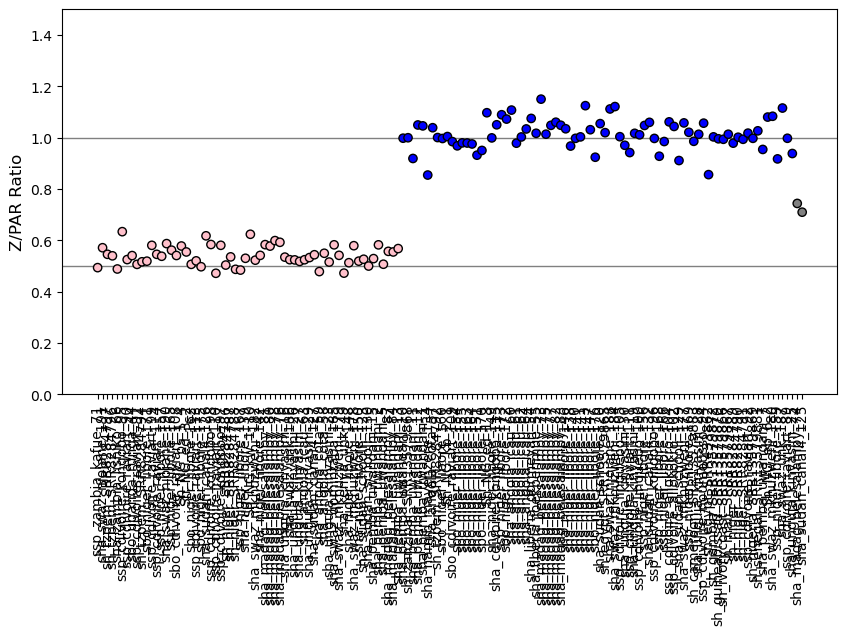

In [93]:
# Color mapping based on sex
colors = summary_df['sex'].map({'male': 'blue', 'female': 'pink', 'unk': 'grey'})

# Plot
plt.figure(figsize=(10, 5))
plt.axhline(y=1, color='grey', label='y = 1', linewidth=1)
plt.axhline(y=0.5, color='grey', label='y = 0.5', linewidth=1)

# Scatter plot with colors based on sex using the 'c' parameter
plt.scatter(range(0, len(summary_df['ratio'])), summary_df['ratio'], c=colors, zorder=5, edgecolors="black")

# Set x-ticks to sample names, rotated 90 degrees
plt.xticks(summary_df.index, summary_df['sample'], rotation=90)

# Setting the y-axis limits
plt.ylim([0, 1.5])
plt.ylabel("Z/PAR Ratio", size=12)

plt.savefig("zw_ratio.png", facecolor="white", dpi=600)
plt.savefig("zw_ratio.svg")

# Show plot
plt.show()


In [94]:
summary_df.loc[summary_df["sex"] == "female", "sample"].to_csv("females.list", sep=",", header=False, index=False)
summary_df.loc[summary_df["sex"] == "male", "sample"].to_csv("males.list", sep=",", header=False, index=False)

In [95]:
summary_df.loc[summary_df["sex"] == "female", "sample"]

0          ssp_zambia_kafue_71
1         sha_swaz_njojane_191
2          sh_tzpem_SRR8284797
3          sh_tzpem_SRR8284796
4        sha_zambia_lishiko_66
                ...           
57        sha_pemba_uwandani_2
58        sha_pemba_uwandani_5
59    sha_madag_belesalampy_87
60    sha_madag_belesalampy_84
61       sha_pemba_uwandani_13
Name: sample, Length: 62, dtype: object

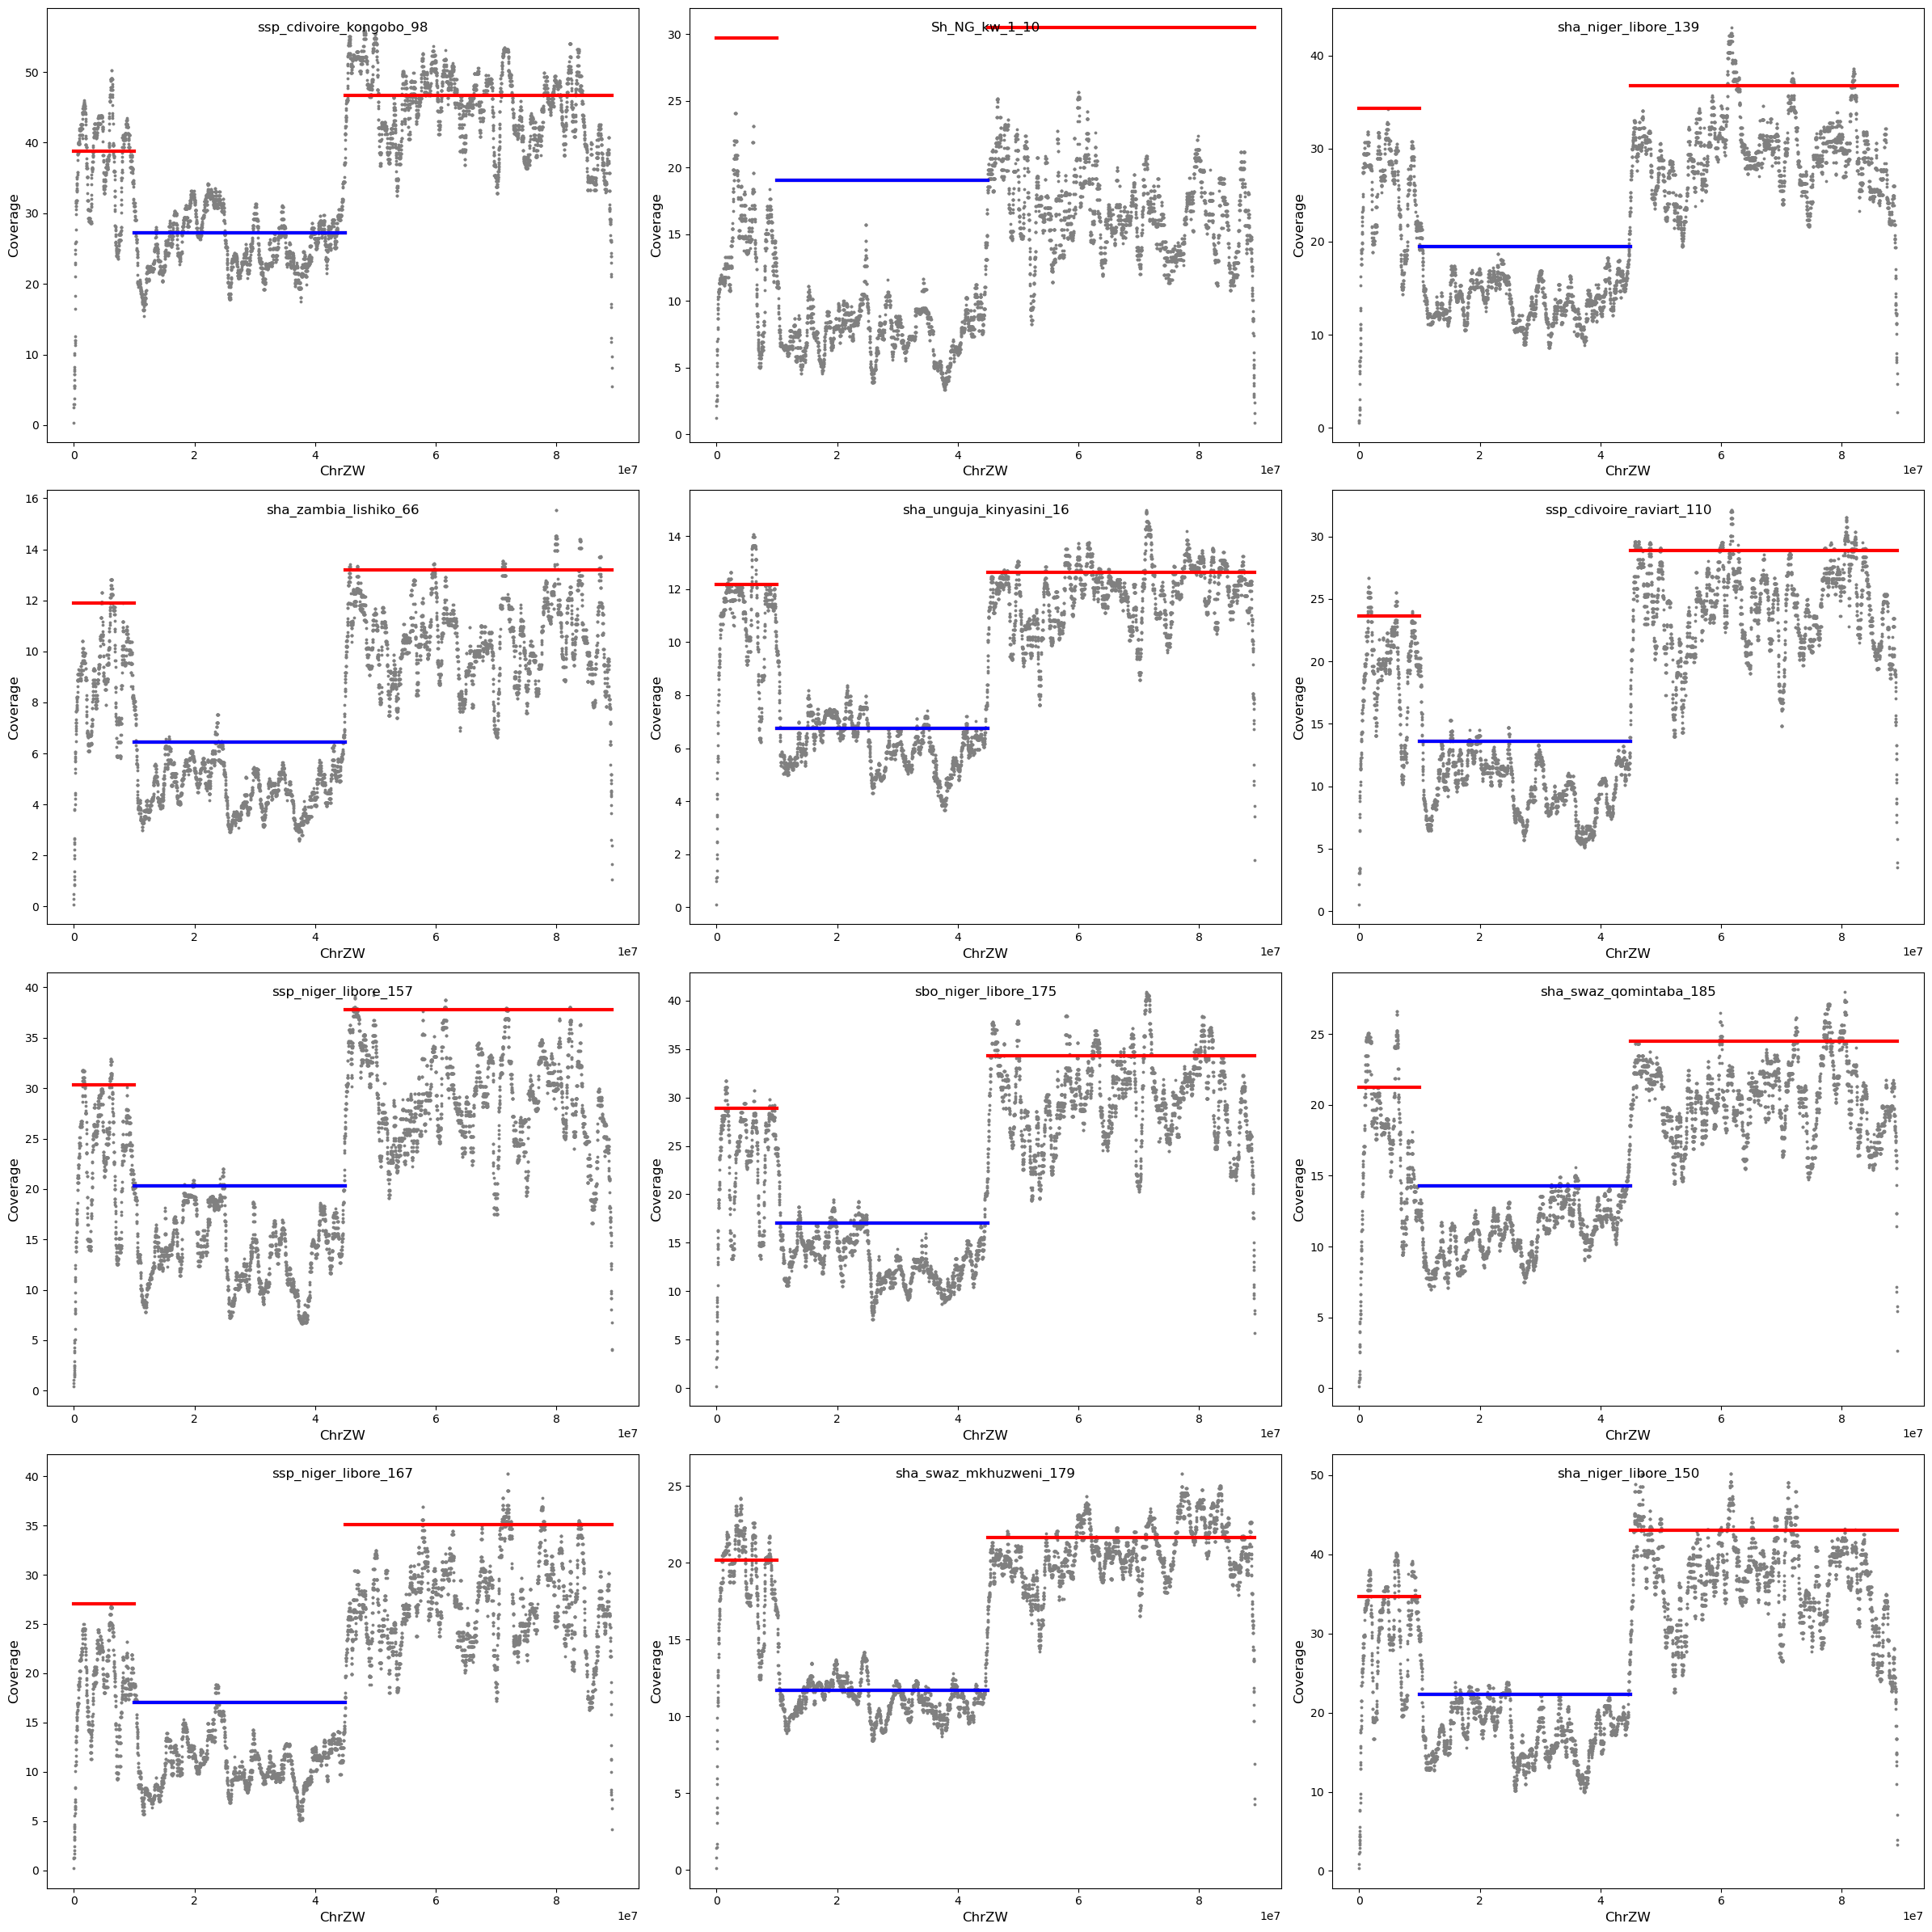

In [96]:
# Load the samples list and select random ones to plot
female_samples = list(summary_df.loc[summary_df["sex"] == "female", "sample"])
female_samples = random.sample(female_samples, 12)

# Calculate the number of rows needed for three columns
n_cols = 3
n_rows = (len(female_samples) + n_cols - 1) // n_cols  # Ensures enough rows to handle all samples

# Prepare the figure and subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(6 * n_rows, 6 * n_rows))
axes = axes.flatten()  # Flatten the 2D array of axes into 1D for easier iteration

for ax, sample in zip(axes, female_samples):
    bed_file = f"{sample}.windows.mean.regions.bed.gz"
    par_file = f"{sample}.par.mean.regions.bed.gz"

    # Load data
    df = pd.read_csv(bed_file, sep='\t', header=None,
                     names=['chrom', 'start', 'end', 'cov'],
                     dtype={'chrom': str, 'start': int, 'end': int, 'cov': float})

    par_df = pd.read_csv(par_file, sep='\t', header=None,
                         names=['chrom', 'start', 'end', 'cov'],
                         dtype={'chrom': str, 'start': int, 'end': int, 'cov': float})

    # Apply median filter
    filtered_data = medfilt(df["cov"], kernel_size=101)


    # Plot filtered data
    ax.scatter(df["start"], filtered_data, s=3, color="grey", alpha=1)

    # Highlight PAR regions
    for index, row in par_df.iterrows():
        ax.plot([row['start'], row['end']], [row['cov'], row['cov']], color="red", linewidth=3)

    z=par_df.iloc[1]
    ax.plot([z['start'], z['end']], [z['cov'], z['cov']], color="blue", linewidth=3)

    # Set labels and title for each subplot
    ax.set_xlabel("ChrZW", size=12)
    ax.set_ylabel("Coverage", size=12)
    ax.set_title(f"{sample}", y=0.93)

# Hide any unused axes if the number of samples isn't a multiple of three
for ax in axes[len(samples):]:
    ax.axis('off')

# Display the figure with all subplots
plt.tight_layout()  # Adjust layout to prevent overlap

plt.savefig("zw_cov.png", facecolor="white", dpi=600)
#plt.savefig("zw_cov.svg")

plt.show()


In [ ]:
plink --vcf your_file.vcf --ld-window 99999 --ld-window-kb 500 --ld-window-r2 0 --out ld_output


In [98]:
%%bash 

conda run -n vcftools --live-stream \
    vcftools \
        --vcf ../post_phase_filtering/chrs_unrelated.vcf \
        --chr NC_067195.1 \
        --keep females.list \
        --recode \
        --recode-INFO-all \
        --stdout \
        >zw_sh_females.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../post_phase_filtering/chrs_unrelated.vcf
	--chr NC_067195.1
	--keep females.list
	--recode-INFO-all
	--recode
	--stdout

Keeping individuals in 'keep' list
After filtering, kept 62 out of 166 Individuals
Outputting VCF file...
After filtering, kept 7227516 out of a possible 35817757 Sites
Run Time = 322.00 seconds


In [99]:
%%bash 

conda run -n vcftools --live-stream \
    vcftools \
        --vcf ../post_phase_filtering/chrs_unrelated.vcf \
        --chr NC_067195.1 \
        --keep males.list \
        --recode \
        --recode-INFO-all \
        --stdout \
        >zw_sh_males.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../post_phase_filtering/chrs_unrelated.vcf
	--chr NC_067195.1
	--keep males.list
	--recode-INFO-all
	--recode
	--stdout

Keeping individuals in 'keep' list
After filtering, kept 77 out of 166 Individuals
Outputting VCF file...
After filtering, kept 7227516 out of a possible 35817757 Sites
Run Time = 343.00 seconds


In [ ]:
plink --vcf your_file.vcf --ld-window 99999 --ld-window-kb 500 --ld-window-r2 0 --out ld_output